# INFO-F-422 -  Statistical Foundations of Machine Learning 

### Student 1 - __[antoine.bedaton@ulb.be](mailto:antoine.bedaton@ulb.be) - Student ID 459482__
### Student 2 - __[pierre.defraene@ulb.be](mailto:pierre.defraene@ulb.be) - Student ID 463941__
### Student 3 - __[nathan.marotte@ulb.be](mailto:nathan.marotte@ulb.be) - Student ID 459274__

### Video presentation: www.youtube.com/abcd1234

## Project Title


# Introduction

Using data from Taarifa and the Tanzanian Ministry of Water, we are asked to predict which pump are functional, non functional, or functional but need some repairs. The data contains information about each pump (position, region name, population, type of payment, installator, etc ...) and comes in 3 files : 

- training_set_labels : Contains the list of all id followed by their status (functionning, non functionning or needing repairs)

- training_set_values : Contains all the information about each pump with their id that correspond to training_set_labels

- test_set_values : The same structure as training_set_values but for which the status is unknown and that we will have to predict.

First, we will preprocess the data to remove redundent or useless information. For exemple the name of the pump isn't really relevant for guessing if it is working or not, while the name of the constructor is.

Once we reduced the size of the input space, we will run our 3 models on the data, that is training_set_values with their status_group column added.

Our group chose the 3 following models : 

- Neural Network (nnet library)
- Decision Tree (rpart library)
- Random Forest (randomForest library)

Uncomment and execute the following cell to install all the require libraries

In [1]:
# install.packages('dummies')
# install.packages('rpart')
# install.packages('rpart.plot')
# install.packages('nnet')
# install.packages('randomForest')

We will be using R in version 3.6.1
This can be checked by executing the following cell

In [2]:
R.version$version.string

[1] "R version 3.6.1 (2019-07-05)"

We will use the data provided by the competition "Pump it Up: Data Mining the Water Table" available [here](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/])

In [3]:
training_set_labels <- read.csv(file = 'data/training_set_labels.csv', stringsAsFactors = T)
test_set_values <- read.csv(file = 'data/test_set_values.csv', stringsAsFactors = T)
training_set_values <- read.csv(file = 'data/training_set_values.csv', stringsAsFactors = T)

#training_set_labels
#summary(test_set_values)

# Data preprocessing

Before starting the modeling, we must first process the data. We are given a huge number of columns and rows, some of which are not useful to determine the functioning of the pump. For instance, maybe the name of the pump is not important to guess if it is working or not.

## Removing useless columns
First we will check all the columns and check if, by chance, one column has always the same value. If there exist such a column, we can safely delete it since it doesn't bring any information to the model.

In [4]:
for (colname in names(training_set_values)) {
    list_of_unique <- unique(training_set_values[colname])
    if (nrow(list_of_unique) == 1){
        print(paste("the column", colname, "has always the same value"))
    }
}

[1] "the column recorded_by has always the same value"


One column was found that is always the same value, we will then remove it from the dataset

In [5]:
training_set_values <- training_set_values[,setdiff(colnames(training_set_values),"recorded_by")] # remove recorded_by

test_set_values <- test_set_values[,setdiff(colnames(test_set_values),"recorded_by")] # remove recorded_by

Now we can look at the data in a less strict manner. What if for only a few of the entries, we have a different value ? This won't be detected with the above loop, but can be detected manually by checking the number of occurence of the most common value. If it appears, let's say more than 99 % of the time, we assume it is always that value and remove that column.

In [6]:

# Computes the ratio of the value that appear the most compared to the rest of the data
maxima <- c()
for (colname in names(training_set_values)) {
   maxima <- rbind(maxima, max(table(training_set_values[colname]))/59400)
}

# Shows it nicely
df <- data.frame(names(training_set_values), maxima)
df <- df[order(df$maxima, decreasing=TRUE),]
head(df)


,names.training_set_values.,maxima
10,num_private,0.9872559
28,management_group,0.8836700
19,public_meeting,0.8587710
31,water_quality,0.8555219
32,quality_group,0.8555219
37,source_class,0.7709428


We see that num_private has almost 99% of the time the same value. Given the huge amount of columns and data, we do not feel that it is necessary to keep that information, it would only make the model more complicated for a slight change in the error rate. Therefore we delete that column.

In [7]:
training_set_values <- training_set_values[,setdiff(colnames(training_set_values),"num_private")] # remove num_private

test_set_values <- test_set_values[,setdiff(colnames(test_set_values),"num_private")] # remove num_private

## Looking at the corelation between columns

When looking through the data, we found multiple columns that were repeated. We suspected that `quantity` and `quantity_group` were highly corolated, so we ran the following command

In [8]:
table(training_set_values$quantity, training_set_values$quantity_group)

              
                 dry enough insufficient seasonal unknown
  dry           6246      0            0        0       0
  enough           0  33186            0        0       0
  insufficient     0      0        15129        0       0
  seasonal         0      0            0     4050       0
  unknown          0      0            0        0     789

It appears that when `quantity` is `dry`, 100% of the time `quantity_group` is also dry. Those two columns have a corelation of 100%, it means one of the two is redundant and can safely be removed.

We could then do that for all the combination of columns, but this isn't efficient and we can decide by ourselves by looking at what the columns represent, and test for corelation between them. This can be done via `chiqs.test` of the contingency table of the two columns. 

For exemple with `quantity` and `quantity_group`

In [9]:
chisq.test(table(training_set_values$quantity, training_set_values$quantity_group))


	Pearson's Chi-squared test

data:  table(training_set_values$quantity, training_set_values$quantity_group)
X-squared = 237600, df = 16, p-value < 2.2e-16


We get a high X-squared value and a very small p-value, this would mean the two columns are highly corrolated.

We then checked all the columns and tested the one we found that might be highly corrolated. Since R is a really bad language, we didn't find a way to do that in a for loop with the name or number of the column in a variable, so we copy-pasted the call with all the columns pair we suspected

In [10]:
head(training_set_values)

chisq.test(table(training_set_values$funder, training_set_values$payment_type))
chisq.test(table(training_set_values$water_quality, training_set_values$quality_group))


id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
69572,6000,2011-03-14,Roman,1390,Roman,34.93809,-9.856322,none,Lake Nyasa,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
8776,0,2013-03-06,Grumeti,1399,GRUMETI,34.69877,-2.147466,Zahanati,Lake Victoria,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
34310,25,2013-02-25,Lottery Club,686,World vision,37.46066,-3.821329,Kwa Mahundi,Pangani,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
67743,0,2013-01-28,Unicef,263,UNICEF,38.48616,-11.155298,Zahanati Ya Nanyumbu,Ruvuma / Southern Coast,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
19728,0,2011-07-13,Action In A,0,Artisan,31.13085,-1.825359,Shuleni,Lake Victoria,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
9944,20,2011-03-13,Mkinga Distric Coun,0,DWE,39.17280,-4.765587,Tajiri,Pangani,...,per bucket,salty,salty,enough,enough,other,other,unknown,communal standpipe multiple,communal standpipe


Warning message in chisq.test(table(training_set_values$funder, training_set_values$payment_type)):
"Chi-squared approximation may be incorrect"


	Pearson's Chi-squared test

data:  table(training_set_values$funder, training_set_values$payment_type)
X-squared = 89600, df = 11382, p-value < 2.2e-16


Warning message in chisq.test(table(training_set_values$water_quality, training_set_values$quality_group)):
"Chi-squared approximation may be incorrect"


	Pearson's Chi-squared test

data:  table(training_set_values$water_quality, training_set_values$quality_group)
X-squared = 297000, df = 35, p-value < 2.2e-16


Description Chi-squared tes TODO


## Missing value imputation

## Feature engineering

## Feature selection
We want to look at the correlation between every input and the output.

In [11]:
test_correlation <- cbind(training_set_values,training_set_labels[2])

chisq.test(table(test_correlation$amount_tsh, test_correlation$status_group))
chisq.test(table(test_correlation$date_recorded, test_correlation$status_group))
chisq.test(table(test_correlation$funder, test_correlation$status_group))
chisq.test(table(test_correlation$gps_height, test_correlation$status_group))
chisq.test(table(test_correlation$installer, test_correlation$status_group))
chisq.test(table(test_correlation$longitude, test_correlation$status_group))
chisq.test(table(test_correlation$latitude, test_correlation$status_group))
chisq.test(table(test_correlation$wpt_name, test_correlation$status_group))
chisq.test(table(test_correlation$basin, test_correlation$status_group))
chisq.test(table(test_correlation$subvillage, test_correlation$status_group))
chisq.test(table(test_correlation$region, test_correlation$status_group))
chisq.test(table(test_correlation$region_code, test_correlation$status_group))
chisq.test(table(test_correlation$district_code, test_correlation$status_group))
chisq.test(table(test_correlation$lga, test_correlation$status_group))
chisq.test(table(test_correlation$ward, test_correlation$status_group))
chisq.test(table(test_correlation$population, test_correlation$status_group))
chisq.test(table(test_correlation$public_meeting, test_correlation$status_group))
chisq.test(table(test_correlation$scheme_management, test_correlation$status_group))
chisq.test(table(test_correlation$scheme_name, test_correlation$status_group))
chisq.test(table(test_correlation$permit, test_correlation$status_group))
chisq.test(table(test_correlation$construction_year, test_correlation$status_group))
chisq.test(table(test_correlation$extraction_type, test_correlation$status_group))
#chisq.test(table(test_correlation$extraction_class, test_correlation$status_group))
chisq.test(table(test_correlation$management, test_correlation$status_group))
chisq.test(table(test_correlation$payment, test_correlation$status_group))
chisq.test(table(test_correlation$water_quality, test_correlation$status_group))
chisq.test(table(test_correlation$quantity, test_correlation$status_group))
chisq.test(table(test_correlation$source, test_correlation$status_group))
chisq.test(table(test_correlation$waterpoint_type, test_correlation$status_group))

Warning message in chisq.test(table(test_correlation$amount_tsh, test_correlation$status_group)):
"Chi-squared approximation may be incorrect"


	Pearson's Chi-squared test

data:  table(test_correlation$amount_tsh, test_correlation$status_group)
X-squared = 4307.2, df = 194, p-value < 2.2e-16


Warning message in chisq.test(table(test_correlation$date_recorded, test_correlation$status_group)):
"Chi-squared approximation may be incorrect"


	Pearson's Chi-squared test

data:  table(test_correlation$date_recorded, test_correlation$status_group)
X-squared = 5005.7, df = 710, p-value < 2.2e-16


Warning message in chisq.test(table(test_correlation$funder, test_correlation$status_group)):
"Chi-squared approximation may be incorrect"


	Pearson's Chi-squared test

data:  table(test_correlation$funder, test_correlation$status_group)
X-squared = 14169, df = 3794, p-value < 2.2e-16


Warning message in chisq.test(table(test_correlation$gps_height, test_correlation$status_group)):
"Chi-squared approximation may be incorrect"


	Pearson's Chi-squared test

data:  table(test_correlation$gps_height, test_correlation$status_group)
X-squared = 6279.7, df = 4854, p-value < 2.2e-16


Warning message in chisq.test(table(test_correlation$installer, test_correlation$status_group)):
"Chi-squared approximation may be incorrect"


	Pearson's Chi-squared test

data:  table(test_correlation$installer, test_correlation$status_group)
X-squared = 14748, df = 4290, p-value < 2.2e-16


Warning message in chisq.test(table(test_correlation$longitude, test_correlation$status_group)):
"Chi-squared approximation may be incorrect"


	Pearson's Chi-squared test

data:  table(test_correlation$longitude, test_correlation$status_group)
X-squared = 112780, df = 115030, p-value = 1


Warning message in chisq.test(table(test_correlation$latitude, test_correlation$status_group)):
"Chi-squared approximation may be incorrect"


	Pearson's Chi-squared test

data:  table(test_correlation$latitude, test_correlation$status_group)
X-squared = 112782, df = 115032, p-value = 1


Warning message in chisq.test(table(test_correlation$wpt_name, test_correlation$status_group)):
"Chi-squared approximation may be incorrect"


	Pearson's Chi-squared test

data:  table(test_correlation$wpt_name, test_correlation$status_group)
X-squared = 77854, df = 74798, p-value = 3.167e-15



	Pearson's Chi-squared test

data:  table(test_correlation$basin, test_correlation$status_group)
X-squared = 1921, df = 16, p-value < 2.2e-16


Warning message in chisq.test(table(test_correlation$subvillage, test_correlation$status_group)):
"Chi-squared approximation may be incorrect"


	Pearson's Chi-squared test

data:  table(test_correlation$subvillage, test_correlation$status_group)
X-squared = 55210, df = 38574, p-value < 2.2e-16



	Pearson's Chi-squared test

data:  table(test_correlation$region, test_correlation$status_group)
X-squared = 4794.6, df = 40, p-value < 2.2e-16


Warning message in chisq.test(table(test_correlation$region_code, test_correlation$status_group)):
"Chi-squared approximation may be incorrect"


	Pearson's Chi-squared test

data:  table(test_correlation$region_code, test_correlation$status_group)
X-squared = 5157.4, df = 52, p-value < 2.2e-16


Warning message in chisq.test(table(test_correlation$district_code, test_correlation$status_group)):
"Chi-squared approximation may be incorrect"


	Pearson's Chi-squared test

data:  table(test_correlation$district_code, test_correlation$status_group)
X-squared = 1673.5, df = 38, p-value < 2.2e-16


Warning message in chisq.test(table(test_correlation$lga, test_correlation$status_group)):
"Chi-squared approximation may be incorrect"


	Pearson's Chi-squared test

data:  table(test_correlation$lga, test_correlation$status_group)
X-squared = 11530, df = 248, p-value < 2.2e-16


Warning message in chisq.test(table(test_correlation$ward, test_correlation$status_group)):
"Chi-squared approximation may be incorrect"


	Pearson's Chi-squared test

data:  table(test_correlation$ward, test_correlation$status_group)
X-squared = 26145, df = 4182, p-value < 2.2e-16


Warning message in chisq.test(table(test_correlation$population, test_correlation$status_group)):
"Chi-squared approximation may be incorrect"


	Pearson's Chi-squared test

data:  table(test_correlation$population, test_correlation$status_group)
X-squared = 4480, df = 2096, p-value < 2.2e-16



	Pearson's Chi-squared test

data:  table(test_correlation$public_meeting, test_correlation$status_group)
X-squared = 384, df = 4, p-value < 2.2e-16


Warning message in chisq.test(table(test_correlation$scheme_management, test_correlation$status_group)):
"Chi-squared approximation may be incorrect"


	Pearson's Chi-squared test

data:  table(test_correlation$scheme_management, test_correlation$status_group)
X-squared = 1991.1, df = 24, p-value < 2.2e-16


Warning message in chisq.test(table(test_correlation$scheme_name, test_correlation$status_group)):
"Chi-squared approximation may be incorrect"


	Pearson's Chi-squared test

data:  table(test_correlation$scheme_name, test_correlation$status_group)
X-squared = 21643, df = 5392, p-value < 2.2e-16



	Pearson's Chi-squared test

data:  table(test_correlation$permit, test_correlation$status_group)
X-squared = 104.18, df = 4, p-value < 2.2e-16


Warning message in chisq.test(table(test_correlation$construction_year, test_correlation$status_group)):
"Chi-squared approximation may be incorrect"


	Pearson's Chi-squared test

data:  table(test_correlation$construction_year, test_correlation$status_group)
X-squared = 4098.4, df = 108, p-value < 2.2e-16


Warning message in chisq.test(table(test_correlation$extraction_type, test_correlation$status_group)):
"Chi-squared approximation may be incorrect"


	Pearson's Chi-squared test

data:  table(test_correlation$extraction_type, test_correlation$status_group)
X-squared = 7365.6, df = 34, p-value < 2.2e-16



	Pearson's Chi-squared test

data:  table(test_correlation$management, test_correlation$status_group)
X-squared = 2081.1, df = 22, p-value < 2.2e-16



	Pearson's Chi-squared test

data:  table(test_correlation$payment, test_correlation$status_group)
X-squared = 3965.6, df = 12, p-value < 2.2e-16


Warning message in chisq.test(table(test_correlation$water_quality, test_correlation$status_group)):
"Chi-squared approximation may be incorrect"


	Pearson's Chi-squared test

data:  table(test_correlation$water_quality, test_correlation$status_group)
X-squared = 2277.4, df = 14, p-value < 2.2e-16



	Pearson's Chi-squared test

data:  table(test_correlation$quantity, test_correlation$status_group)
X-squared = 11361, df = 8, p-value < 2.2e-16


Warning message in chisq.test(table(test_correlation$source, test_correlation$status_group)):
"Chi-squared approximation may be incorrect"


	Pearson's Chi-squared test

data:  table(test_correlation$source, test_correlation$status_group)
X-squared = 2624, df = 18, p-value < 2.2e-16


Warning message in chisq.test(table(test_correlation$waterpoint_type, test_correlation$status_group)):
"Chi-squared approximation may be incorrect"


	Pearson's Chi-squared test

data:  table(test_correlation$waterpoint_type, test_correlation$status_group)
X-squared = 7450.3, df = 12, p-value < 2.2e-16


In [12]:
options(repr.matrix.max.rows=10, repr.matrix.max.cols=100) # option pour la taille des prints



 #table(training_set_values$waterpoint_type_group, training_set_values$waterpoint_type)  # less information
training_set_values <- training_set_values[,setdiff(colnames(training_set_values),"waterpoint_type_group")]

test_set_values <- test_set_values[,setdiff(colnames(test_set_values),"waterpoint_type_group")]

 #table(training_set_values$source_type, training_set_values$source_class)  # less information
training_set_values <- training_set_values[,setdiff(colnames(training_set_values),"source_class")]

test_set_values <- test_set_values[,setdiff(colnames(test_set_values),"source_class")]

 #table(training_set_values$source, training_set_values$source_type)  # less information
training_set_values <- training_set_values[,setdiff(colnames(training_set_values),"source_type")]

test_set_values <- test_set_values[,setdiff(colnames(test_set_values),"source_type")]

 #table(training_set_values$water_quality, training_set_values$quality_group)  # less information
training_set_values <- training_set_values[,setdiff(colnames(training_set_values),"quality_group")]

test_set_values <- test_set_values[,setdiff(colnames(test_set_values),"quality_group")]
 #table(training_set_values$quantity, training_set_values$quantity_group)  # equivalent, we delete column
training_set_values <- training_set_values[,setdiff(colnames(training_set_values),"quantity_group")]

test_set_values <- test_set_values[,setdiff(colnames(test_set_values),"quantity_group")]

 #table(training_set_values$extraction_type, training_set_values$extraction_type_group)  # we can delete column
training_set_values <- training_set_values[,setdiff(colnames(training_set_values),"extraction_type_group")]

test_set_values <- test_set_values[,setdiff(colnames(test_set_values),"extraction_type_group")]

 #table(training_set_values$extraction_type, training_set_values$extraction_type_class)  # We can delete column
#training_set_values <- training_set_values[,setdiff(colnames(training_set_values),"extraction_type_class")]
# table(training_set_values$payment, training_set_values$payment_type)  # equivalent,  we delete column
training_set_values <- training_set_values[,setdiff(colnames(training_set_values),"payment_type")]

test_set_values <- test_set_values[,setdiff(colnames(test_set_values),"payment_type")]

 #table(training_set_values$management, training_set_values$management_group)  # we delete column
training_set_values <- training_set_values[,setdiff(colnames(training_set_values),"management_group")]

test_set_values <- test_set_values[,setdiff(colnames(test_set_values),"management_group")]

 #table(training_set_values$region, training_set_values$region_code)  # very correlated but some cities/code are ambigius
# table(training_set_values$basin, training_set_values$subvillage)  # not really correlated, keep


# head(training_set_values)
names(training_set_values)
length(names(training_set_values))
#training_set_values[-c(40, 38, 37, 33, 35, 26, 27, 31, 29, 14, 12)]
training_set_values
# subvillage > region 
training_set_labels


[1] "id"                    "amount_tsh"            "date_recorded"        
 [4] "funder"                "gps_height"            "installer"            
 [7] "longitude"             "latitude"              "wpt_name"             
[10] "basin"                 "subvillage"            "region"               
[13] "region_code"           "district_code"         "lga"                  
[16] "ward"                  "population"            "public_meeting"       
[19] "scheme_management"     "scheme_name"           "permit"               
[22] "construction_year"     "extraction_type"       "extraction_type_class"
[25] "management"            "payment"               "water_quality"        
[28] "quantity"              "source"                "waterpoint_type"

[1] 30

id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_class,management,payment,water_quality,quantity,source,waterpoint_type
69572,6000,2011-03-14,Roman,1390,Roman,34.93809,-9.856322,none,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,VWC,Roman,False,1999,gravity,gravity,vwc,pay annually,soft,enough,spring,communal standpipe
8776,0,2013-03-06,Grumeti,1399,GRUMETI,34.69877,-2.147466,Zahanati,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,,Other,,True,2010,gravity,gravity,wug,never pay,soft,insufficient,rainwater harvesting,communal standpipe
34310,25,2013-02-25,Lottery Club,686,World vision,37.46066,-3.821329,Kwa Mahundi,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,vwc,pay per bucket,soft,enough,dam,communal standpipe multiple
67743,0,2013-01-28,Unicef,263,UNICEF,38.48616,-11.155298,Zahanati Ya Nanyumbu,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,VWC,,True,1986,submersible,submersible,vwc,never pay,soft,dry,machine dbh,communal standpipe multiple
19728,0,2011-07-13,Action In A,0,Artisan,31.13085,-1.825359,Shuleni,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,,,True,0,gravity,gravity,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60739,10,2013-05-03,Germany Republi,1210,CES,37.16981,-3.253847,Area Three Namba 27,Pangani,Kiduruni,Kilimanjaro,3,5,Hai,Masama Magharibi,125,True,Water Board,Losaa Kia water supply,True,1999,gravity,gravity,water board,pay per bucket,soft,enough,spring,communal standpipe
27263,4700,2011-05-07,Cefa-njombe,1212,Cefa,35.24999,-9.070629,Kwa Yahona Kuvala,Rufiji,Igumbilo,Iringa,11,4,Njombe,Ikondo,56,True,VWC,Ikondo electrical water sch,True,1996,gravity,gravity,vwc,pay annually,soft,enough,river,communal standpipe
37057,0,2011-04-11,,0,,34.01709,-8.750434,Mashine,Rufiji,Madungulu,Mbeya,12,7,Mbarali,Chimala,0,True,VWC,,False,0,swn 80,handpump,vwc,pay monthly,fluoride,enough,machine dbh,hand pump
31282,0,2011-03-08,Malec,0,Musa,35.86132,-6.378573,Mshoro,Rufiji,Mwinyi,Dodoma,1,4,Chamwino,Mvumi Makulu,0,True,VWC,,True,0,nira/tanira,handpump,vwc,never pay,soft,insufficient,shallow well,hand pump


id,status_group
69572,functional
8776,functional
34310,functional
67743,non functional
19728,functional
...,...
60739,functional
27263,functional
37057,functional
31282,functional


At this time, we have remove the column which gave less information or was redundant. Now, we want to replace the empty cells by unknown.

In [13]:
#head(training_set_values, 10)[3, 2]
empty_check <- c("funder", "installer", "basin", "subvillage", "region", "lga", "ward", "scheme_management", "scheme_name", "permit", "extraction_type", "extraction_type_class", "payment", "water_quality", "quantity", "source", "waterpoint_type", "permit", "public_meeting") 
for (row in 1:nrow(head(training_set_values, 10))){
    #print(training_set_values[row])
    for (col in 1:ncol(head(training_set_values, 10))){
        col_name <- names(training_set_values[row])
        if (col_name %in% empty_check){
            if (is.na(training_set_values[row, col])){
                print(paste("Changing"))
                training_set_values[row, col] = as.factor("unknown")
            }
        }
    }
}
head(training_set_values)

id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_class,management,payment,water_quality,quantity,source,waterpoint_type
69572,6000,2011-03-14,Roman,1390,Roman,34.93809,-9.856322,none,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,VWC,Roman,False,1999,gravity,gravity,vwc,pay annually,soft,enough,spring,communal standpipe
8776,0,2013-03-06,Grumeti,1399,GRUMETI,34.69877,-2.147466,Zahanati,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,,Other,,True,2010,gravity,gravity,wug,never pay,soft,insufficient,rainwater harvesting,communal standpipe
34310,25,2013-02-25,Lottery Club,686,World vision,37.46066,-3.821329,Kwa Mahundi,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,vwc,pay per bucket,soft,enough,dam,communal standpipe multiple
67743,0,2013-01-28,Unicef,263,UNICEF,38.48616,-11.155298,Zahanati Ya Nanyumbu,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,VWC,,True,1986,submersible,submersible,vwc,never pay,soft,dry,machine dbh,communal standpipe multiple
19728,0,2011-07-13,Action In A,0,Artisan,31.13085,-1.825359,Shuleni,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,,,True,0,gravity,gravity,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe
9944,20,2011-03-13,Mkinga Distric Coun,0,DWE,39.17280,-4.765587,Tajiri,Pangani,Moa/Mwereme,Tanga,4,8,Mkinga,Moa,1,True,VWC,Zingibali,True,2009,submersible,submersible,vwc,pay per bucket,salty,enough,other,communal standpipe multiple


## End of preprocessing

We need to transform also categorical variable with 'one-hot-encoding'. To do so, we will use `dummies` package. To facilitate the work, we will merge the training set and the test set to have all different possibilities for each columns.

In [23]:
library(dummies)

total_data <- rbind(training_set_values,test_set_values)

factor_variables <- which(sapply(total_data[1,],class)=="factor")

data_fact <- total_data[,factor_variables]

only_num_var <- total_data[,-factor_variables]

variables_to_keep <- c("ward", "waterpoint_type","quantity","extraction_type")

data_factor_onehot <- dummy.data.frame(data_fact[,variables_to_keep], sep="_")


data_factor_onehot[1:2,]

dim(total_data)
dim(training_set_values)

total_with_dummies <- cbind(only_num_var,data_factor_onehot)

# data_train
data_train <- total_with_dummies[1:59400,]
data_train <- cbind(data_train, training_set_labels[2])

data_train


# data_test
data_test <- total_with_dummies[59401:74250,]


Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
"non-list contrasts argument ignored"Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
"non-list contrasts argument ignored"Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
"non-list contrasts argument ignored"Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
"non-list contrasts argument ignored"

ward_Aghondi,ward_Akheri,ward_Arash,ward_Arri,ward_Arusha Chini,ward_Babayu,ward_Badi,ward_Badugu,ward_Bahi,ward_Balangidalalu,ward_Baleni,ward_Bangata,ward_Bangwe,ward_Baraa,ward_Bargish,ward_Bariadi,ward_Barikiwa,ward_Barray,ward_Bashay,ward_Bashinet,ward_Bassodesh,ward_Bassotu,ward_Bendera,ward_Berega,ward_Berege,ward_Bereko,ward_Bigwa,ward_Biharamulo Urban,ward_Biirabo,ward_Binagi,ward_Biro,ward_Bitale,ward_Boma,ward_Boma la ng'ombe,ward_Bombambili,ward_Bombo,ward_Bonde la Songwe,ward_Bondeni,ward_Bonga,ward_Bubiki,ward_Buchambi,ward_Budakwa,ward_Budekwa,ward_Budushi,ward_Bugandika,ward_Buganguzi,ward_Bugarama,ward_Bugene,ward_Bugogwe,ward_Bugomora,...,ward_Wotta,ward_Yaeda Chini,ward_Yakobi,ward_Yombo,ward_Zagayu,ward_Zanka,ward_Ziba,ward_Zinga/Ikerege,ward_Zirai,ward_Ziwani,ward_Zoissa,ward_Zombo,ward_Zongomera,ward_Zuzu,ward_Gorong'a,ward_Kang'ata,ward_Mdabulo,ward_Mwalugulu,ward_Mwamashimba,ward_Sange,waterpoint_type_cattle trough,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other,quantity_dry,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown,extraction_type_afridev,extraction_type_cemo,extraction_type_climax,extraction_type_gravity,extraction_type_india mark ii,extraction_type_india mark iii,extraction_type_ksb,extraction_type_mono,extraction_type_nira/tanira,extraction_type_other,extraction_type_other - mkulima/shinyanga,extraction_type_other - play pump,extraction_type_other - rope pump,extraction_type_other - swn 81,extraction_type_submersible,extraction_type_swn 80,extraction_type_walimi,extraction_type_windmill
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


[1] 74250    30

[1] 59400    30

id,amount_tsh,gps_height,longitude,latitude,region_code,district_code,population,construction_year,ward_Aghondi,ward_Akheri,ward_Arash,ward_Arri,ward_Arusha Chini,ward_Babayu,ward_Badi,ward_Badugu,ward_Bahi,ward_Balangidalalu,ward_Baleni,ward_Bangata,ward_Bangwe,ward_Baraa,ward_Bargish,ward_Bariadi,ward_Barikiwa,ward_Barray,ward_Bashay,ward_Bashinet,ward_Bassodesh,ward_Bassotu,ward_Bendera,ward_Berega,ward_Berege,ward_Bereko,ward_Bigwa,ward_Biharamulo Urban,ward_Biirabo,ward_Binagi,ward_Biro,ward_Bitale,ward_Boma,ward_Boma la ng'ombe,ward_Bombambili,ward_Bombo,ward_Bonde la Songwe,ward_Bondeni,ward_Bonga,ward_Bubiki,ward_Buchambi,...,ward_Yaeda Chini,ward_Yakobi,ward_Yombo,ward_Zagayu,ward_Zanka,ward_Ziba,ward_Zinga/Ikerege,ward_Zirai,ward_Ziwani,ward_Zoissa,ward_Zombo,ward_Zongomera,ward_Zuzu,ward_Gorong'a,ward_Kang'ata,ward_Mdabulo,ward_Mwalugulu,ward_Mwamashimba,ward_Sange,waterpoint_type_cattle trough,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other,quantity_dry,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown,extraction_type_afridev,extraction_type_cemo,extraction_type_climax,extraction_type_gravity,extraction_type_india mark ii,extraction_type_india mark iii,extraction_type_ksb,extraction_type_mono,extraction_type_nira/tanira,extraction_type_other,extraction_type_other - mkulima/shinyanga,extraction_type_other - play pump,extraction_type_other - rope pump,extraction_type_other - swn 81,extraction_type_submersible,extraction_type_swn 80,extraction_type_walimi,extraction_type_windmill,status_group
69572,6000,1390,34.93809,-9.856322,11,5,109,1999,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,functional
8776,0,1399,34.69877,-2.147466,20,2,280,2010,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,functional
34310,25,686,37.46066,-3.821329,21,4,250,2009,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,functional
67743,0,263,38.48616,-11.155298,90,63,58,1986,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,non functional
19728,0,0,31.13085,-1.825359,18,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60739,10,1210,37.16981,-3.253847,3,5,125,1999,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,functional
27263,4700,1212,35.24999,-9.070629,11,4,56,1996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,functional
37057,0,0,34.01709,-8.750434,12,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,functiona

# Model selection

First of All, we decided to use the decision tree considering that it is one of the simplest machine learning technique.


## Model 1

id,amount_tsh,gps_height,longitude,latitude,region_code,district_code,population,construction_year,ward_Aghondi,ward_Akheri,ward_Arash,ward_Arri,ward_Arusha Chini,ward_Babayu,ward_Badi,ward_Badugu,ward_Bahi,ward_Balangidalalu,ward_Baleni,ward_Bangata,ward_Bangwe,ward_Baraa,ward_Bargish,ward_Bariadi,ward_Barikiwa,ward_Barray,ward_Bashay,ward_Bashinet,ward_Bassodesh,ward_Bassotu,ward_Bendera,ward_Berega,ward_Berege,ward_Bereko,ward_Bigwa,ward_Biharamulo Urban,ward_Biirabo,ward_Binagi,ward_Biro,ward_Bitale,ward_Boma,ward_Boma la ng'ombe,ward_Bombambili,ward_Bombo,ward_Bonde la Songwe,ward_Bondeni,ward_Bonga,ward_Bubiki,ward_Buchambi,...,ward_Yaeda Chini,ward_Yakobi,ward_Yombo,ward_Zagayu,ward_Zanka,ward_Ziba,ward_Zinga/Ikerege,ward_Zirai,ward_Ziwani,ward_Zoissa,ward_Zombo,ward_Zongomera,ward_Zuzu,ward_Gorong'a,ward_Kang'ata,ward_Mdabulo,ward_Mwalugulu,ward_Mwamashimba,ward_Sange,waterpoint_type_cattle trough,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other,quantity_dry,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown,extraction_type_afridev,extraction_type_cemo,extraction_type_climax,extraction_type_gravity,extraction_type_india mark ii,extraction_type_india mark iii,extraction_type_ksb,extraction_type_mono,extraction_type_nira/tanira,extraction_type_other,extraction_type_other - mkulima/shinyanga,extraction_type_other - play pump,extraction_type_other - rope pump,extraction_type_other - swn 81,extraction_type_submersible,extraction_type_swn 80,extraction_type_walimi,extraction_type_windmill,status_group
69572,6000,1390,34.93809,-9.856322,11,5,109,1999,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,functional
8776,0,1399,34.69877,-2.147466,20,2,280,2010,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,functional
34310,25,686,37.46066,-3.821329,21,4,250,2009,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,functional
67743,0,263,38.48616,-11.155298,90,63,58,1986,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,non functional
19728,0,0,31.13085,-1.825359,18,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60739,10,1210,37.16981,-3.253847,3,5,125,1999,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,functional
27263,4700,1212,35.24999,-9.070629,11,4,56,1996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,functional
37057,0,0,34.01709,-8.750434,12,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,functiona


FALSE  TRUE 
 2811 12039 

,id,status_group
59401,50785,non functional
59402,51630,functional
59403,17168,non functional
59404,45559,non functional
59405,49871,functional
...,...,...
74246,39307,functional
74247,18990,functional
74248,28749,functional
74249,33492,functional


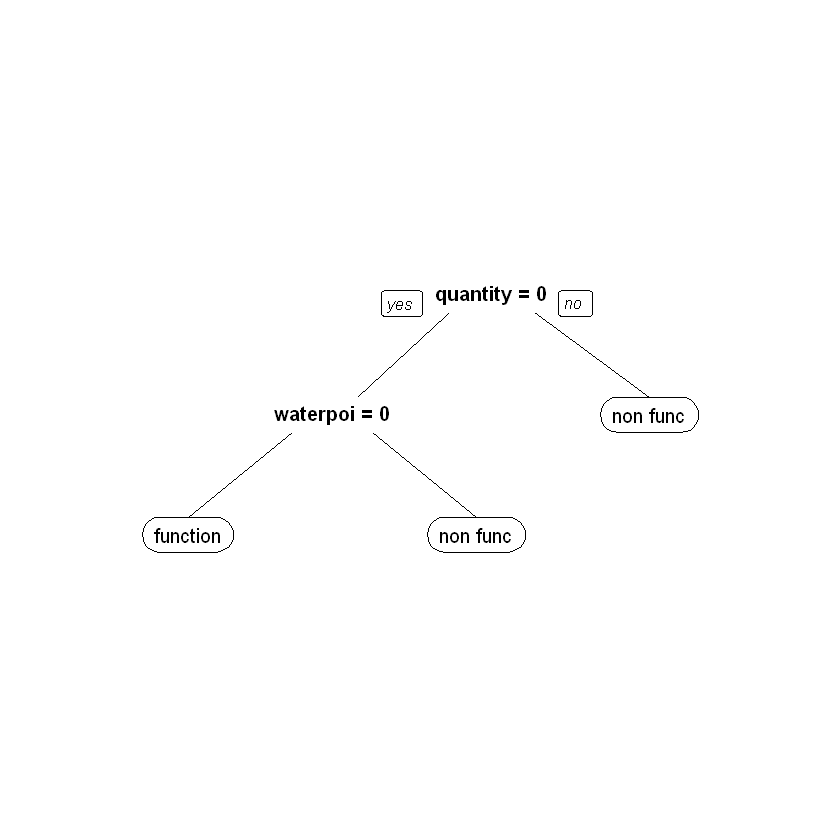

In [24]:
library(rpart)
library(rpart.plot)

data_train

# example model 

#DS <- cbind(X, functionnal=Y)
#data_train doit encore être défini data input + status_group

model<- rpart(status_group~., data= data_train, method = 'class') # what we need to change according of the model
#model<- rpart(status_group~., data= training_with_dummy, method = 'class')

prp(model)

predict_unseen <- predict(model,data_test, type = 'class')
#predict_unseen <- predict(model,test_with_dummy, type = 'class')

status_group <-predict_unseen

data_predict <- test_set_values




data_predict <- cbind(data_predict[1],status_group)

table(data_predict["status_group"] == "functional")

data_predict

write.csv(data_predict,"decisionTree.csv",row.names = FALSE)

## Model 2

We will also try to make the prediction with neural networks.

In [ ]:
library(nnet)

data_train

# example model 

#DS <- cbind(X, functionnal=Y)
#data_train doit encore être défini data input + status_group

nnet_model <- nnet(status_group~., data= data_train, size = 8, decay=5e-4, maxit=200) # what we need to change according of the model

predict_unseen <- predict(nnet_model, data_test, type= 'class')

status_group <-predict_unseen

nnet_data_predict <- cbind(data_predict[1],status_group)

nnet_data_predict

table(nnet_data_predict["status_group"] == "functional")

write.csv(nnet_data_predict,"NeuralNetwork.csv",row.names = FALSE)

In [ ]:
#predict_unseen <- predict(nnet_model,only_num_var_train, type= 'class') # test nathan with know variable

In [ ]:
#results <- table(ifelse(predict_unseen == training_set_labels$status_group, "true", "false"))
#results["true"]/(results["true"]+results["false"])

## Model 3

In [25]:
library("randomForest")

rf_model<- randomForest(status_group~., data= data_train) # what we need to change according of the model


rf_predict_unseen <- predict(rf_model,data_test, type = 'class')

rf_predict_unseen

status_group <-rf_predict_unseen

rf_data_predict <- test_set_values


rf_data_predict <- cbind(data_predict[1],status_group)


rf_data_predict

write.csv(rf_data_predict,"randomForest.csv",row.names = FALSE)

ERROR: Error in eval(predvars, data, env): objet 'ward_Arusha Chini' introuvable


In [ ]:
rf_model

# Alternative models





# Conclusions